## 変分量子アルゴリズム

まず、VQEの元になっている**変分量子アルゴリズム**（*Variational Quantum Algorithm*, VQA）と呼ばれる手法について見ていきます。

In [ ]:
import sys
import shutil
import tarfile
from google.colab import drive

drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.10/site-packages')

!git clone -b branch-2024 https: // github.com / UTokyo-ICEPP / qc-workbook-lecturenotes
!cp -r qc-workbook-lecturenotes / qc_workbook / root /.local / lib / python3.10 / site-packages /

In [37]:
# Tested with python 3.10.14, qiskit 1.0.2, numpy 1.26.4, scipy 1.13.0
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_aer import AerSimulator

### 変分フォームを使った実例
ではここで、$U$ゲート一つからなる単一量子ビットの変分フォームを利用してパラメータ最適化の例を実行してみましょう。ランダムに量子状態$|\psi_0\rangle$を選び、$|\psi(\theta, \phi\rangle := U(\theta, \phi, 0)|0\rangle$でそれを近似するという問題を考えます。

In [38]:
rng = np.random.default_rng(999999)

# 与えられた量子ビット数（nq）に応じたランダムな状態ベクトルを作る関数
def random_statevector(nq):
    # 2^nqの複素数をランダムに生成
    data = rng.random(2 ** nq) + 1.j * rng.random(2 ** nq)
    # 正規化
    data /= np.sqrt(np.sum(np.square(np.abs(data))))

    return Statevector(data)

# 例：U(π/3, π/6, 0)|0>
statevector = Statevector(np.array([np.cos(np.pi / 6.), np.exp(1.j * np.pi / 6.) * np.sin(np.pi / 6.)]))
for pauli in ['X', 'Y', 'Z']:
    op = SparsePauliOp(pauli)
    print(f'<{pauli}> = {statevector.expectation_value(op).real:.5f}')

<X> = 0.75000
<Y> = 0.43301
<Z> = 0.50000


次に、変分フォーム回路を定義します。このとき、$U$ゲートの回転角として、具体的な数値を設定せず、QiskitのParameterというオブジェクトを利用します。Parameterはあとから数値を代入できる名前のついた箱として使えます。

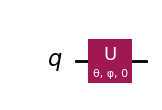

In [39]:
theta = Parameter('θ')
phi = Parameter('φ')

ansatz_1q = QuantumCircuit(1)
ansatz_1q.u(theta, phi, 0., 0)

# Parameterの値は未定
ansatz_1q.draw('mpl')

Parameterに値を代入するには、回路の`assign_parameters`メソッドを利用します。

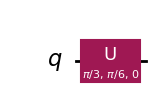

In [40]:
# thetaとphiにπ/3とπ/6を代入
ansatz_1q.assign_parameters({theta: np.pi / 3., phi: np.pi / 6.}).draw('mpl')

変分フォーム回路が作る状態における$X, Y, Z$の期待値を測定するための回路を定義します。

In [41]:
circuits = dict()

# <X>を測るにはHゲートで基底を変換する
circuits['X'] = ansatz_1q.copy()
circuits['X'].h(0)
circuits['X'].measure_all()

# <Y>を測るにはSdg, Hゲートで基底を変換する
circuits['Y'] = ansatz_1q.copy()
circuits['Y'].sdg(0)
circuits['Y'].h(0)
circuits['Y'].measure_all()

# <Z>はそのままの回路で測れる
circuits['Z'] = ansatz_1q.copy()
circuits['Z'].measure_all()

それぞれの回路を通常通りバックエンドの`run()`メソッドで実行し、結果から期待値を計算する関数を定義します。

In [42]:
backend = AerSimulator()

def circuit_expval(circuit, param_vals):
    bound_circuit = circuit.assign_parameters({theta: param_vals[0], phi: param_vals[1]})

    bound_circuit_tr = transpile(bound_circuit, backend=backend)
    # shotsは関数の外で定義する
    job = backend.run(bound_circuit_tr, shots=shots)
    counts = job.result().get_counts()

    return (counts.get('0', 0) - counts.get('1', 0)) / shots

# 例：U(π/3, π/6, 0)|0>
shots = 10000
param_vals = [np.pi / 3., np.pi / 6.]
for pauli in ['X', 'Y', 'Z']:
    print(f'<{pauli}> = {circuit_expval(circuits[pauli], param_vals):.5f}')

<X> = 0.76280
<Y> = 0.44240
<Z> = 0.48700


最小化する目的関数を定義します。

In [43]:
def objective_function(param_vals):
    loss = 0.
    for pauli in ['X', 'Y', 'Z']:
        # target_state_1qは関数の外で定義する
        op = SparsePauliOp(pauli)
        target = target_state_1q.expectation_value(op).real
        current = circuit_expval(circuits[pauli], param_vals)
        loss += (target - current) ** 2

    return loss

# 最適化の1ステップごとに呼び出される関数。目的関数の値をリストに記録しておく
def callback_function(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function(param_vals))

最適化には使用しませんが、解を得たあとで変分フォームの終状態とターゲット状態とのフィデリティ$|\langle \psi_0 | \psi(\theta, \phi) \rangle|^2$を計算する関数も定義しておきます。厳密に最適化が成功すれば、この関数の返り値は1になります。

In [44]:
def fidelity(ansatz, param_vals, target_state):
    # 量子回路のパラメータのリストはcircuit.parametersで取得できる
    parameters = ansatz.parameters

    param_binding = dict(zip(parameters, param_vals))
    opt_ansatz = ansatz.assign_parameters(param_binding)

    # Statevectorは回路からも生成可能（回路を|0>に対して適用した終状態になる）
    circuit_state = Statevector(opt_ansatz)

    return np.square(np.abs(target_state.inner(circuit_state)))

最後にCOBYLAオプティマイザーのインスタンスを作成し、アルゴリズムを実行します。

In [45]:
# COBYLAの最大ステップ数
maxiter = 300
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

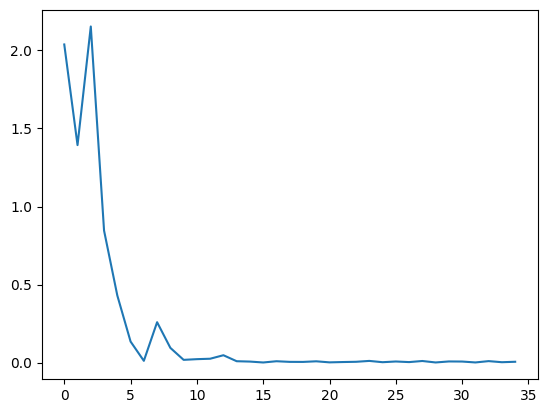

In [46]:
# ターゲット状態
target_state_1q = random_statevector(1)

# thetaを[0, π), phiを[0, 2π)からランダムに選ぶ
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function, x0=init)

plt.plot(losses);

In [47]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9989080992603564

#### Estimatorの利用

VQEを含む変分量子アルゴリズムでは、上のように変分フォームにパラメータ値を代入し複数の観測量の期待値を計算するという手順の繰り返しが頻出します。そのため、これを自動化し、かつ（今は利用しませんが）様々なエラー補正なども適応してくれるEstimatorというクラスを使用することが推奨されています。特に、ここではBackendEstimatorという、特定のバックエンドを利用して計算をするタイプのEstimatorを利用します。

In [48]:
# BackendEstimatorインスタンスの生成
estimator = BackendEstimator(backend)

# 観測量はSparsePauliOpオブジェクトで表現
observables = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

param_vals = [np.pi / 3., np.pi / 6.]

# 変分フォーム、観測量、パラメータ値をrun()に渡す
# 観測量が3つあるので、ansatz_1qとparam_valuesも3つずつ
job = estimator.run([ansatz_1q] * 3, observables, [param_vals] * 3, shots=10000)
result = job.result()
print(result.values)

[0.755  0.4272 0.4956]


Estimatorを使った目的関数を定義します。

In [49]:
observables_1q = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

def objective_function_estimator(param_vals):
    target = np.array(list(target_state_1q.expectation_value(op).real for op in observables_1q))

    job = estimator.run([ansatz_1q] * len(observables_1q), observables_1q, [param_vals] * len(observables_1q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_estimator(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function_estimator(param_vals))

上の目的関数を最適化します

In [50]:
# COBYLAの最大ステップ数
maxiter = 300
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_estimator)

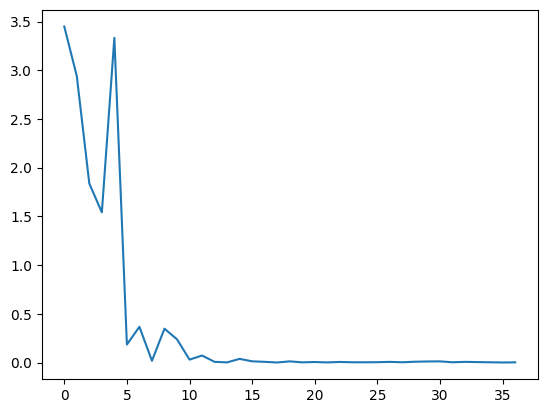

In [51]:
# ターゲット状態
target_state_1q = random_statevector(1)

# thetaを[0, π), phiを[0, 2π)からランダムに選ぶ
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function_estimator, x0=init)

plt.plot(losses);

In [52]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9993377482963123

### エンタングルメントの導入

では次に、この問題を2量子ビットに拡張してやってみましょう。ここでは最も一般的に2量子ビット状態を決定する15個の観測量の期待値

$$
\langle O_1 O_2 \rangle \quad (O_1, O_2 = I, X, Y, Z; O_1 O_2 \neq II)
$$

を測定します。ここで$I$は恒等演算子です。

ターゲット状態に関する関数`random_statevector`と`pauli_expval`はそのまま利用できます。まず変分フォームとして2つの量子ビットに$U$ゲートが一つずつかかっているものを考えて、最小化すべき目的関数を定義します。

In [70]:
# パラメータ数4なので、4要素のパラメータベクトルを作る
params = ParameterVector('params', 4)

ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)

In [71]:
paulis_1q = ['I', 'X', 'Y', 'Z']
paulis_2q = list(f'{op1}{op2}' for op1 in paulis_1q for op2 in paulis_1q if (op1, op2) != ('I', 'I'))
observables_2q = list(SparsePauliOp(pauli) for pauli in paulis_2q)

def objective_function_2q(param_vals):
    # target_state_2qは関数の外で定義
    target = np.array(list(target_state_2q.expectation_value(op).real for op in observables_2q))

    job = estimator.run([ansatz_2q] * len(observables_2q), observables_2q, [param_vals] * len(observables_2q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_2q(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function_2q(param_vals))

In [72]:
# COBYLAの最大ステップ数
maxiter = 300
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_2q)

# ターゲット状態
target_state_2q = random_statevector(2)
#target_state_2q = Statevector(np.array([1., 0., 0., 1.], dtype=complex) / np.sqrt(2.))

# パラメータの初期値
init = rng.uniform(0., 2. * np.pi, size=4)

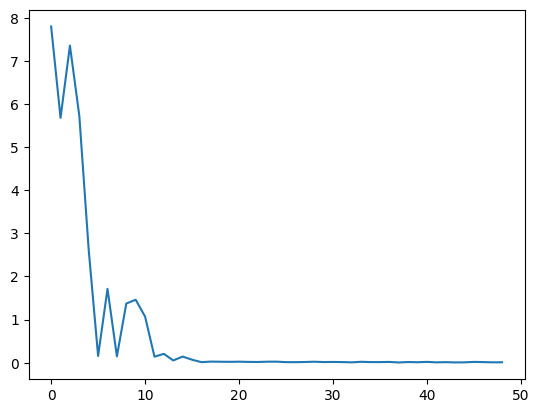

In [73]:
# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function_2q, x0=init)
plt.plot(losses);

In [74]:
fidelity(ansatz_2q, min_result.x, target_state_2q)

0.9996495928720015

やってみると分かりますが、結果は1量子ビットの場合と比べて良くないですね。どうすれば良くなるでしょうか？（やり方は複数あると思います）

**一つの解決策：変分フォームにエンタングルメントを導入する**

```python
ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)
ansatz_2q.cx(0, 1)
```

どうなるか確かめてください。

2量子ビットの一般の状態では2つのビットがエンタングルしているので、変分フォームに2量子ビットゲートを入れると近似精度が良くなるのはある意味当然です。例えば、ベル状態（[CHSH不等式の破れを確認する](https://utokyo-icepp.github.io/qc-workbook/chsh_inequality.html#id14)を参照）を再現したいときにこの状況をクリアに見ることができます。上で

```python
target_state_2q = random_statevector(2)
```

を

```python
target_state_2q = Statevector(np.array([1., 0., 0., 1.], dtype=complex) / np.sqrt(2.))
```

として実行するとどうなるでしょうか。エンタングルさせる場合とさせない場合で大きな違いが見えるでしょう。

## 変分量子固有値ソルバー法

それでは、ここからVQEの実装例を見ていくことにします。

### VQEの実装例1
最初に、パラメータシフト法を使って簡単なVQEの例を実装してみます。ある観測量の期待値が最小になるように、VQEを使ってAnsatzを更新する回路パラメータを決定するという問題を考えてみます。

量子回路として、$R_YR_Z$ゲートを繰り返すシンプルなパラメータ回路を使い、観測量として、パウリ演算子のテンソル積$ZXY$を使います。

最終的に、3通りのVQEを使って求めた最小エネルギーの近似解を、厳密対角化して求めた最小エネルギーの値と比較することにします。

In [80]:
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import CG, GradientDescent
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

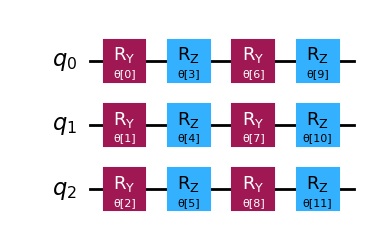

In [81]:
# Ansatzの定義
num_qubits = 3   # 量子ビット数
num_layers = 2  # レイヤー数

ansatz = QuantumCircuit(num_qubits)

# 長さ0のパラメータ配列
theta = ParameterVector('θ')

# 配列に要素を一つ足して、新しく足されたパラメータを返す
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for _ in range(num_layers):
    for iq in range(num_qubits):
        ansatz.ry(new_theta(), iq)

    for iq in range(num_qubits):
        ansatz.rz(new_theta(), iq)

    #for iq in range(num_qubits - 1):
    #    ansatz.cx(iq, iq + 1)

ansatz.draw('mpl')

In [77]:
# 最小固有値を求める観測量
obs = SparsePauliOp('ZXY')

# パラメータの初期値
init = rng.uniform(0., 2. * np.pi, size=len(theta))

# Estimatorを使って観測量の勾配を計算するオブジェクト
grad = ParamShiftEstimatorGradient(estimator)

# Conjugate gradientを使ったVQE
optimizer_cg = CG(maxiter=200)
vqe_cg = VQE(estimator, ansatz, optimizer_cg, gradient=grad, initial_point=init)

# Gradient descentを使ったVQE
optimizer_gd = GradientDescent(maxiter=200)
vqe_gd = VQE(estimator, ansatz, optimizer_gd, gradient=grad, initial_point=init)

# COBYLAを使ったVQE
optimizer_cobyla = COBYLA(maxiter=300)
vqe_cobyla = VQE(estimator, ansatz, optimizer_cobyla, initial_point=init)

# 厳密解を計算するソルバー
ee = NumPyMinimumEigensolver()

In [78]:
result_vqe_cg = vqe_cg.compute_minimum_eigenvalue(obs)
result_vqe_gd = vqe_gd.compute_minimum_eigenvalue(obs)
result_vqe_cobyla = vqe_cobyla.compute_minimum_eigenvalue(obs)
result_ee = ee.compute_minimum_eigenvalue(obs)

In [79]:
print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(COBYLA) = {result_vqe_cobyla.optimal_value}')
print(f'  VQE(CG)    = {result_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_vqe_gd.optimal_value}')

Result:
  Exact      = -1.0
  VQE(COBYLA) = -0.962890625
  VQE(CG)    = -1.0
  VQE(GD)    = -0.87109375


### VQEの実装例2

次に、物理的なモデルを考え、その最低エネルギーを近似的に求めるという問題を考えてみます。VQEは元々このような問題に対する解決法の一つとして提案されたのでした。ここで考える物理モデルは、物性物理のベンチマークとしてしばしば取り上げられる「横磁場イジング模型」です。

アンザッツとして、Ryゲートと制御Zゲートからなる回路を使ってみます。

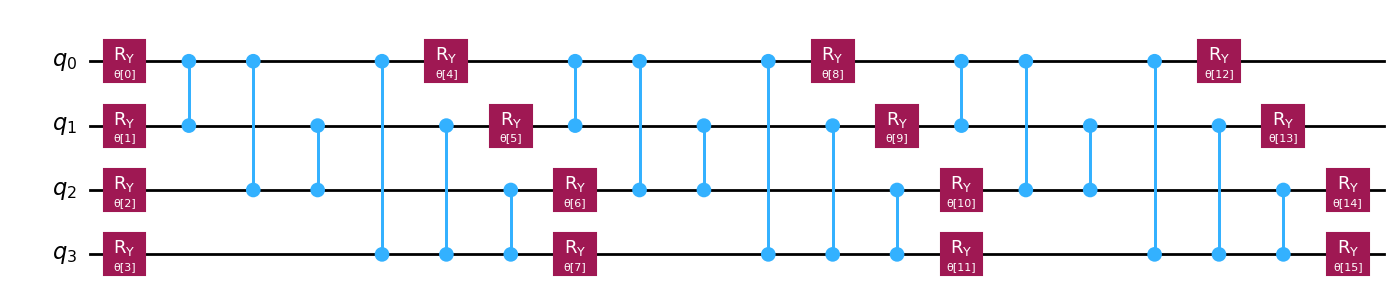

In [82]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

# VQEの設定
num_qubits = 4

ansatz = TwoLocal(num_qubits, "ry", "cz", reps=3)  # Ry gates with trainable parameters and CZ for entanglement
optimizer = SLSQP(maxiter=1000)  # Classical optimizer
ansatz.decompose().draw('mpl')

ここでは、横磁場と縦磁場の混合度合いを表すパラメータ`alpha`を入れることにします。`alpha = 0`が純粋な横磁場、`alpha = pi/2`が純粋な縦磁場のモデルに対応しています。


In [83]:
# Estimatorを使う
estimator = Estimator()

# QiskitのVQEクラスを使う
vqe = VQE(estimator, ansatz, optimizer)

# 横磁場と縦磁場を持つイジング模型のハミルトニアンを定義
def get_hamiltonian(L, J, h, alpha=0):

    # タプル型の変数として、ハミルトニアンの各項からなるリストを定義
    # (1) パウリ列
    # (2) パウリ列に対応する量子ビットのインデックス
    # (3) パウリ列の係数
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # `from_sparse_list`を使い、SparsePauliOpとしてハミルトニアンを作る
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

 例として、`alpha = pi/8`として、縦磁場と横磁場が混ざっているケースでの基底エネルギーをVQEで求めてみます。隣接ビット間の結合定数は`J = 0.2`、磁場との結合定数は`h = 1.2`とします。

In [84]:
# パラメータの設定
J = 0.2
h = 1.2
alpha = np.pi/8
H = get_hamiltonian(L=num_qubits, J=J, h=h, alpha=alpha)

# VQEで最低エネルギー状態を求める
result = vqe.compute_minimum_eigenvalue(H)
#print(result)
print(f'VQE energy value = {result.optimal_value:.5f}')

VQE energy value = -4.92731


系のサイズが小さいので、厳密対角化して最低エネルギーを計算することが可能です。

In [85]:
# ハミルトニアンを厳密体格化し、基底エネルギーを求める
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H)
ref_value = result.eigenvalue.real
print(f"Reference energy value = {ref_value:.5f}")

Reference energy value = -4.92733
